In [1]:
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
COLORS = sns.color_palette('colorblind')

In [2]:
if os.getenv('CONTAINER_BASE_DIR'):
    API_DIRECTORY_URL = 'http://api:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()
    directory['result'] = {k: v.replace('localhost', 'api') 
                           for k, v in directory['result'].items()}
else:
    API_DIRECTORY_URL = 'http://localhost:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()

In [3]:
raw_best_params_data = requests.get(directory['result']['get_grid_best_params']).json()

## Grid Search Model Metrics <a class="anchor" id="4-bullet"></a>

In [5]:
raw_grid_data = requests.get(directory['result']['get_grid_cv_results_model_data']).json()

df = pd.DataFrame()
for record in raw_grid_data['result']:
    grid_record = record['message']['data']
    df_grid = pd.DataFrame(grid_record)
    df = pd.concat([df, df_grid], ignore_index=True)

df_grid_melt = df.melt(id_vars=['exp_id'], var_name="metrics", value_name="scores")    

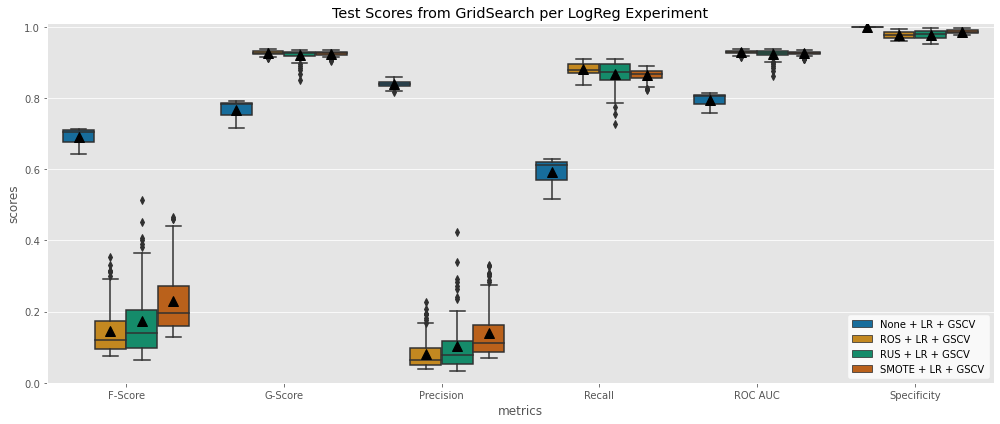

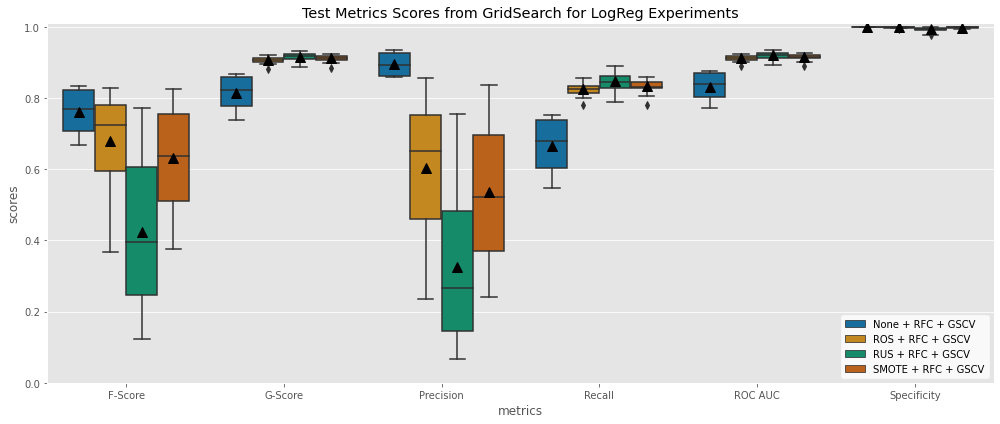

In [6]:
## LogReg
_ = plt.figure(figsize=[14,6])
exp_condition = df_grid_melt['exp_id'].str.contains('LR')
metric_condition = df_grid_melt['metrics'].str.contains('mean_test_')
mask = exp_condition & metric_condition
meanprops = {
    'markerfacecolor':'black', 
    'markeredgecolor':'black',
    'markersize':'10',
}
ax = sns.boxplot(
    data=df_grid_melt[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    showmeans=True,
    meanprops=meanprops,
    palette='colorblind')
plt.xticks(range(6), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC', 'Specificity'])
plt.legend(loc='lower right', frameon=True).get_frame().set_color('white')
plt.ylim([0,1.01])
plt.title('Test Scores from GridSearch per LogReg Experiment')
plt.tight_layout()

## RanFor
_ = plt.figure(figsize=[14,6])
exp_condition = df_grid_melt['exp_id'].str.contains('RFC')
metric_condition = df_grid_melt['metrics'].str.contains('mean_test_')
mask = exp_condition & metric_condition
meanprops = {
    'markerfacecolor':'black', 
    'markeredgecolor':'black',
    'markersize':'10',
}
ax = sns.boxplot(
    data=df_grid_melt[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    showmeans=True,
    meanprops=meanprops,
    palette='colorblind')
plt.xticks(range(6), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC', 'Specificity'])
plt.legend(loc='lower right', frameon=True).get_frame().set_color('white')
plt.ylim([0,1.01])
plt.title('Test Metrics Scores from GridSearch for LogReg Experiments')
plt.tight_layout()

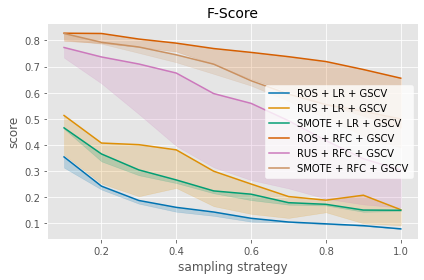

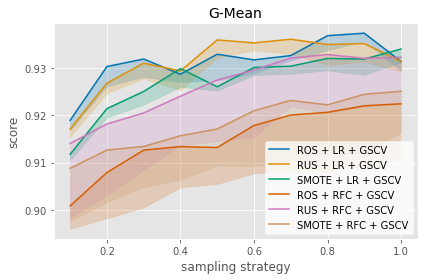

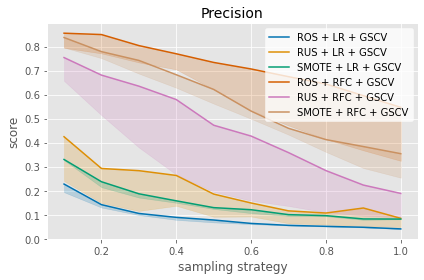

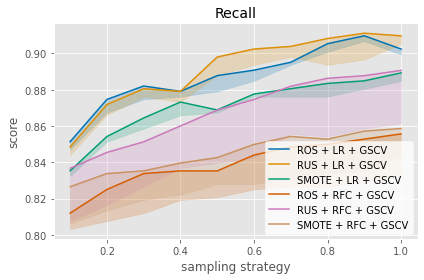

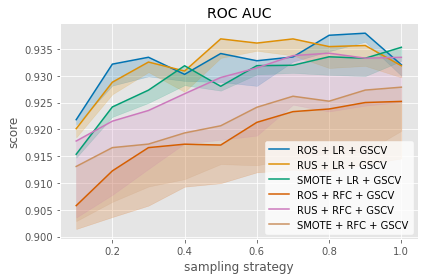

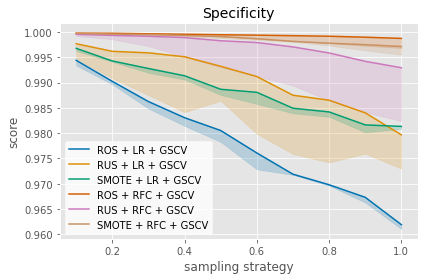

In [7]:
df.loc[df['param_resampling__sampling_strategy'].isnull(), 'param_resampling__sampling_strategy'] = ''

titles = ['F-Score', 'G-Mean', 'Precision', 'Recall', 'ROC AUC', 'Specificity']
metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = (df['param_resampling__sampling_strategy'] != '')
cols = ['exp_id', 'param_resampling__sampling_strategy'] + metrics

for index, metric in enumerate(metrics):
    _ = plt.figure(figsize=[6,4])
    ax = sns.lineplot(
        data=df.loc[mask, cols],
        x='param_resampling__sampling_strategy',
        y=metric,
        hue='exp_id',
        estimator=np.max,
        palette='colorblind')
#     for container in ax.containers:
#         labels = [f'{value:.1f}%' for value in container.datavalues*100]
#         ax.bar_label(container, labels, label_type='center', color='white', rotation=30)
    plt.legend(loc='best', frameon=True).get_frame().set_color('white')
    plt.title(titles[index], fontsize=14)
    plt.xlabel('sampling strategy')
    plt.ylabel('score')
    plt.tight_layout()

In [8]:
metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = df['param_resampling__sampling_strategy'] != ''
cols = ['exp_id', 'param_estimator__C'] + metrics
df.loc[mask, cols].groupby(['exp_id', 'param_estimator__C']).max()

mean_test_f1  \
exp_id            param_estimator__C                 
ROS + LR + GSCV   0.001000                0.354262   
                  0.002855                0.313125   
                  0.008149                0.311514   
                  0.023263                0.291661   
                  0.066408                0.313341   
                  0.189574                0.299299   
                  0.541170                0.279571   
                  1.544859                0.330670   
                  4.410059                0.312868   
                  12.589254               0.278731   
RUS + LR + GSCV   0.001000                0.512903   
                  0.002855                0.452330   
                  0.008149                0.361943   
                  0.023263                0.365981   
                  0.066408                0.312856   
                  0.189574                0.303299   
                  0.541170                0.299227   
                  1.544859                0.281603   
                  4.410059                0.273508   
                  12.589254               0.289484   
SMOTE + LR + GSCV 0.001000                0.465450   
                  0.002855                0.433782   
                  0.008149                0.440828   
                  0.023263                0.461543   
                  0.066408                0.440351   
                  0.189574                0.415596   
                  0.541170                0.406088   
                  1.544859                0.461592   
                  4.410059                0.437591   
                  12.589254               0.419421   

                                      mean_test_geometric_mean_score  \
exp_id            param_estimator__C                                   
ROS + LR + GSCV   0.001000                                  0.935656   
                  0.002855                                  0.934585   
                  0.008149                                  0.936818   
                  0.023263                                  0.937349   
                  0.066408                                  0.933936   
                  0.189574                                  0.934831   
                  0.541170                                  0.934228   
                  1.544859                                  0.937084   
                  4.410059                                  0.935555   
                  12.589254                                 0.935902   
RUS + LR + GSCV   0.001000                                  0.905705   
                  0.002855                                  0.919321   
                  0.008149                                  0.927672   
                  0.023263                                  0.932399   
                  0.066408                                  0.936074   
                  0.189574                                  0.934039   
                  0.541170                                  0.935160   
                  1.544859                                  0.935920   
                  4.410059                                  0.933752   
                  12.589254                                 0.935303   
SMOTE + LR + GSCV 0.001000                                  0.928779   
                  0.002855                                  0.931879   
                  0.008149                                  0.930014   
                  0.023263                                  0.932010   
                  0.066408                                  0.930681   
                  0.189574                                  0.931479   
                  0.541170                                  0.934004   
                  1.544859                                  0.930375   
                  4.410059                                  0.931797   
                  12.589254                                 0.929357   

    

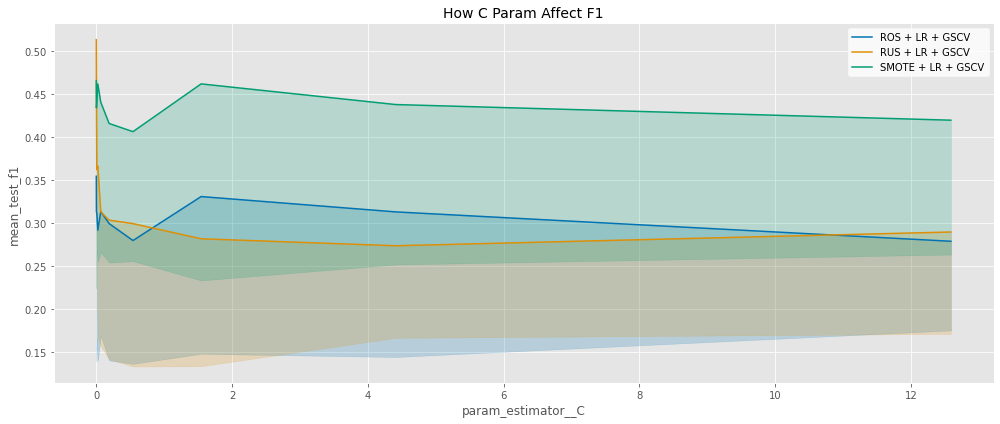

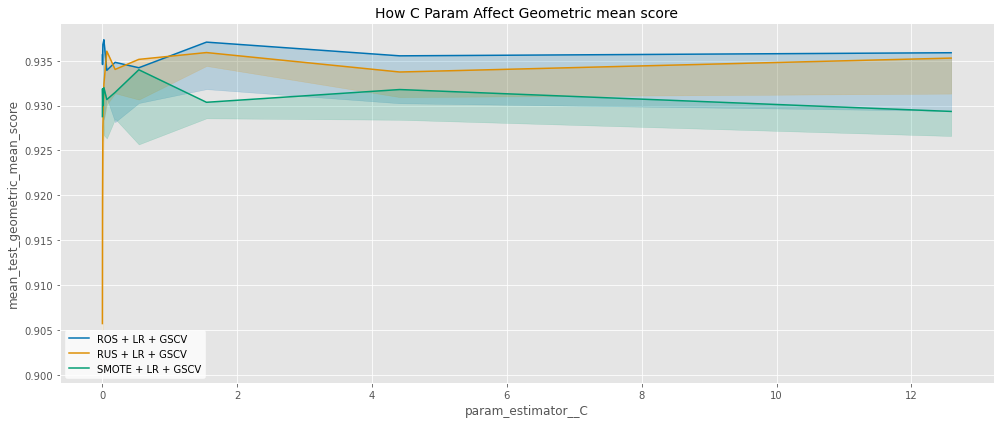

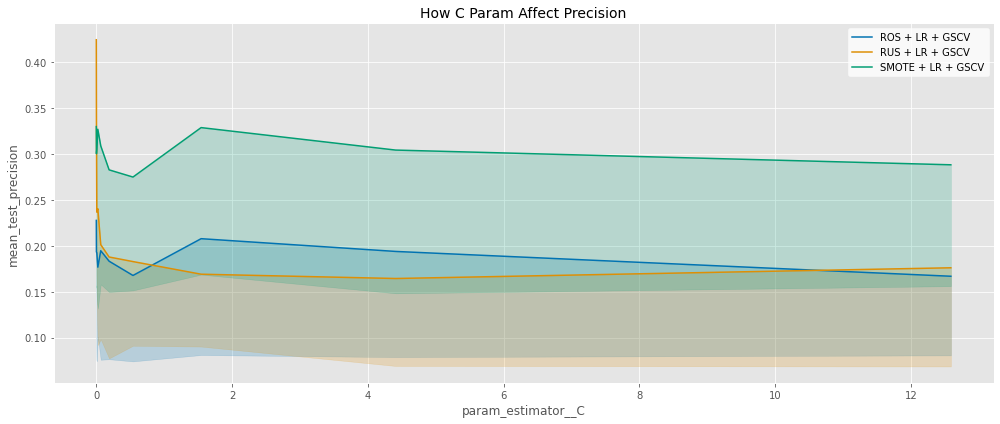

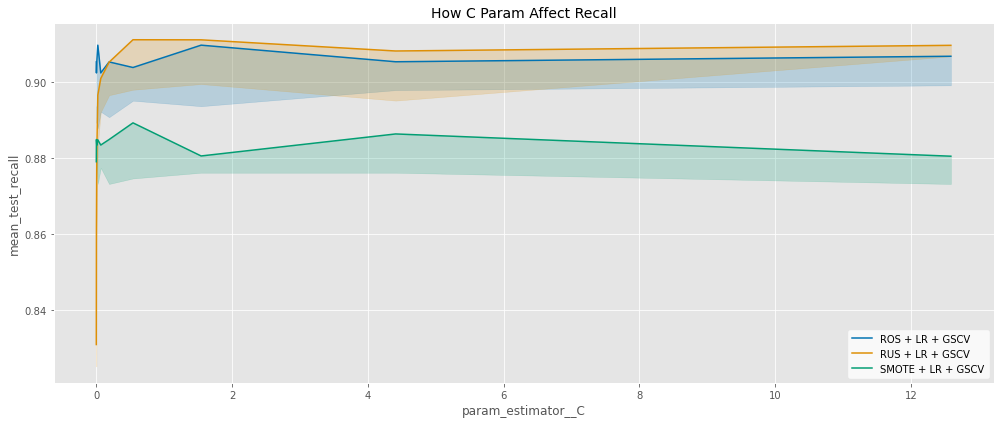

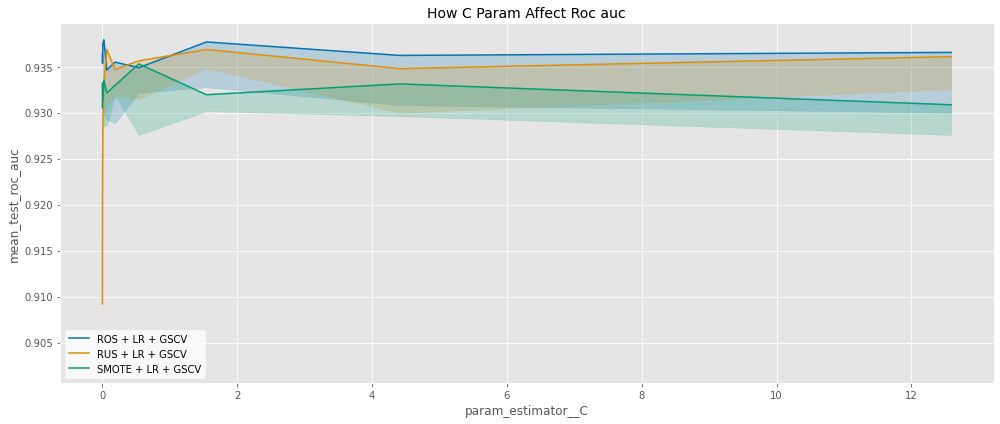

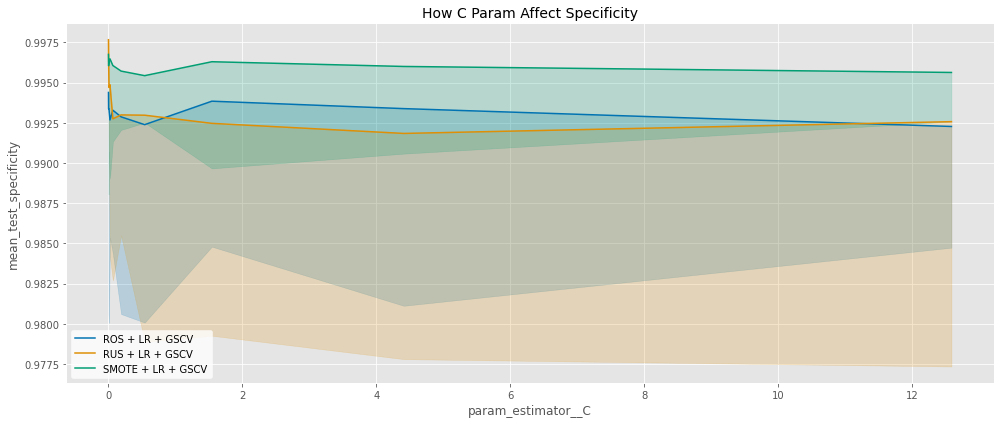

In [9]:
metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = ~(df['param_estimator__C'].isnull())
cols = ['exp_id', 'param_estimator__C'] + metrics

for metric in metrics:
    _ = plt.figure(figsize=[14,6])
    ax = sns.lineplot(
        data=df.loc[mask, cols],
        x='param_estimator__C',
        y=metric,
        hue='exp_id',
        estimator=np.max,
        palette='colorblind')
    plt.legend(loc='best', frameon=True).get_frame().set_color('white')
    pretty_metric = metric.replace('mean_test_', '').replace('_', ' ').capitalize()
    plt.title(f'How C Param Affect {pretty_metric}', fontsize=14)
    plt.tight_layout()

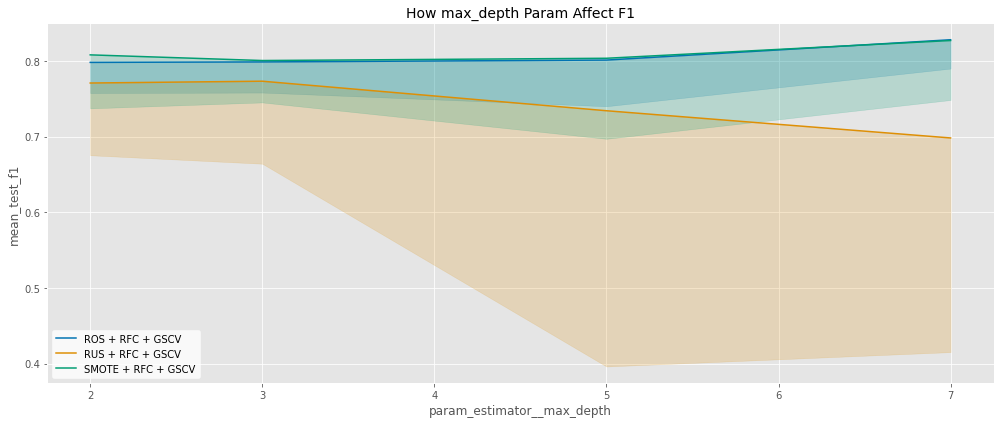

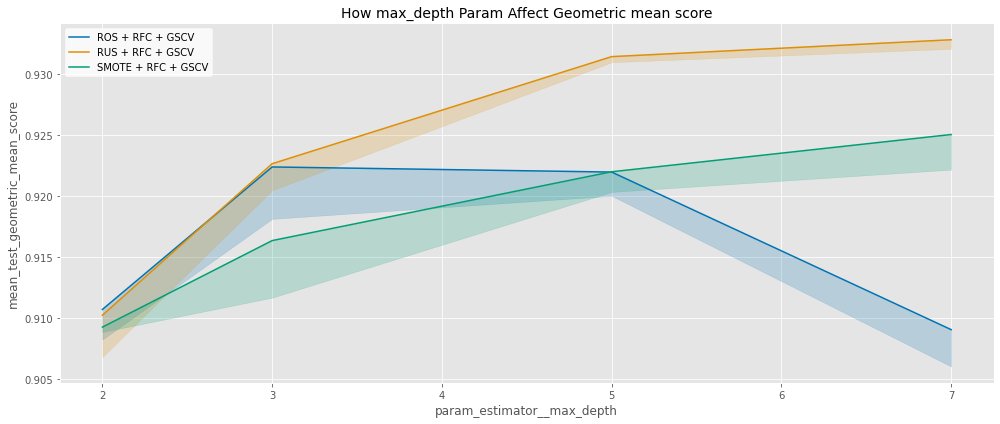

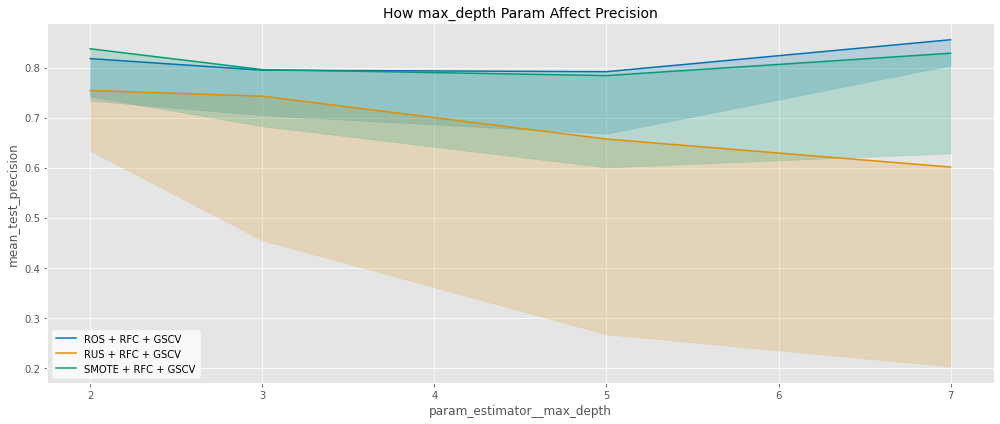

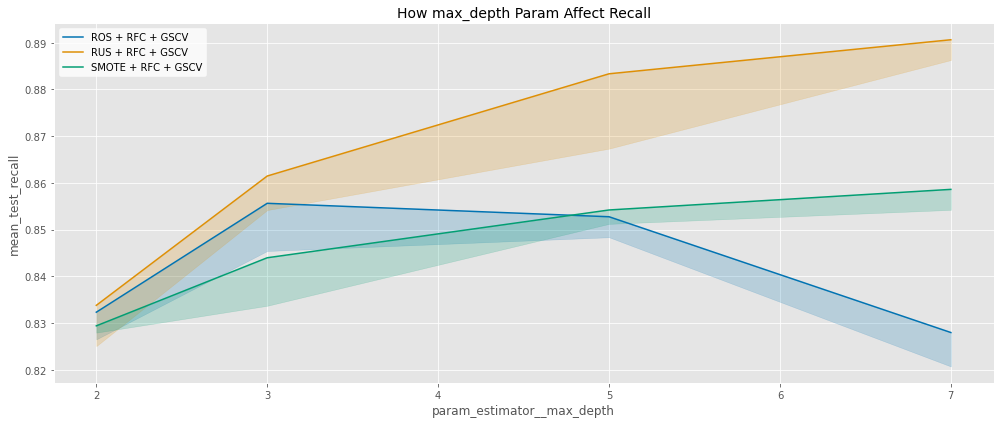

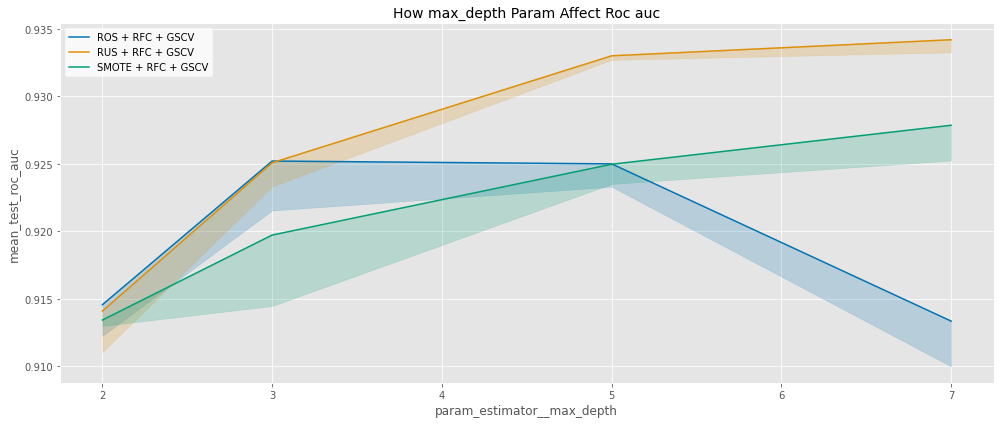

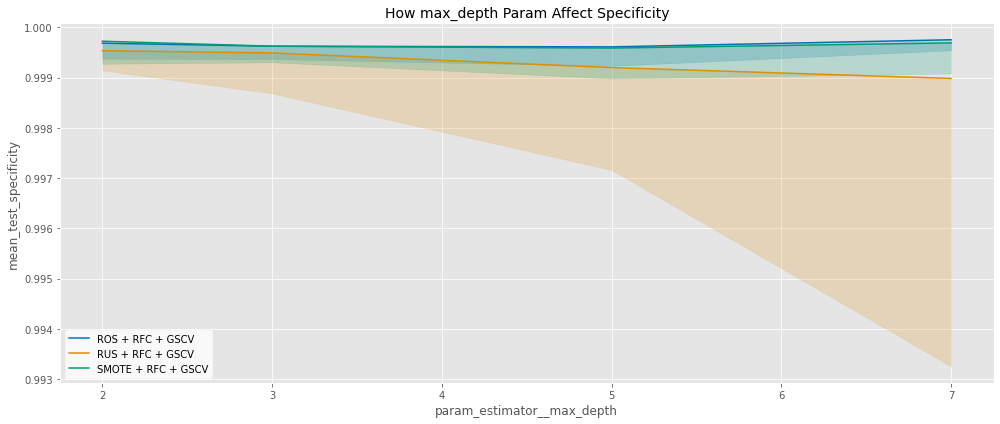

In [10]:
metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = ~(df['param_estimator__max_depth'].isnull())
cols = ['exp_id', 'param_estimator__max_depth'] + metrics

for metric in metrics:
    _ = plt.figure(figsize=[14,6])
    ax = sns.lineplot(
        data=df.loc[mask, cols],
        x='param_estimator__max_depth',
        y=metric,
        hue='exp_id',
        estimator=np.max,
        palette='colorblind')
    plt.legend(loc='best', frameon=True).get_frame().set_color('white')
    pretty_metric = metric.replace('mean_test_', '').replace('_', ' ').capitalize()
    plt.title(f'How max_depth Param Affect {pretty_metric}', fontsize=14)
    plt.tight_layout()

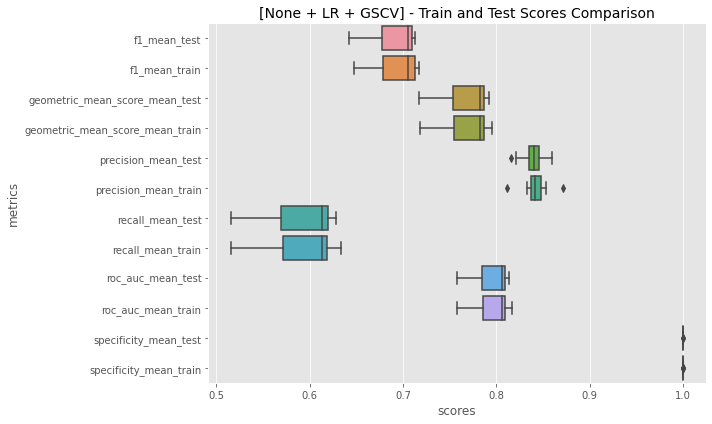

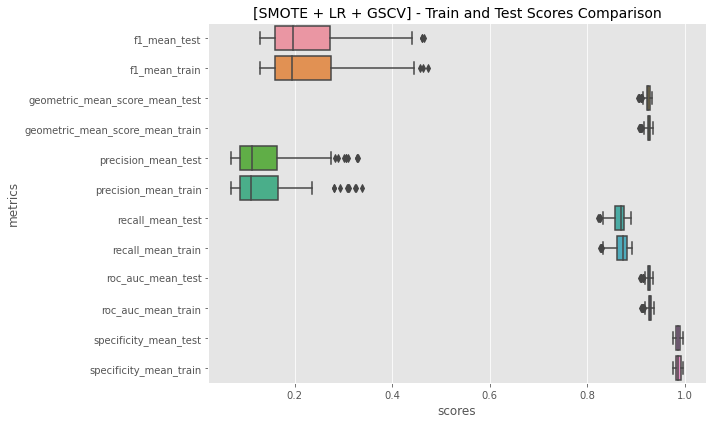

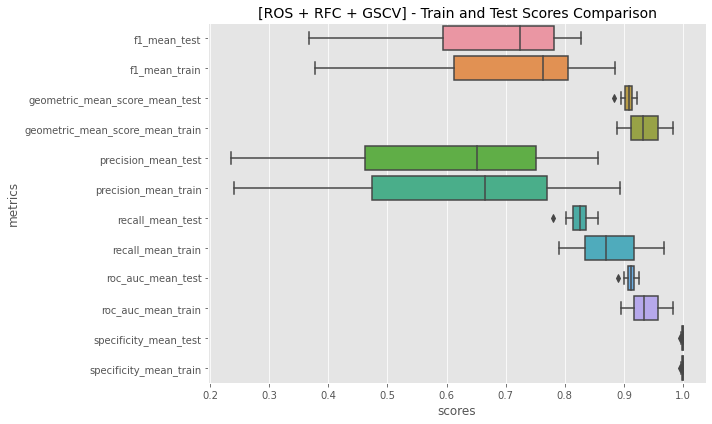

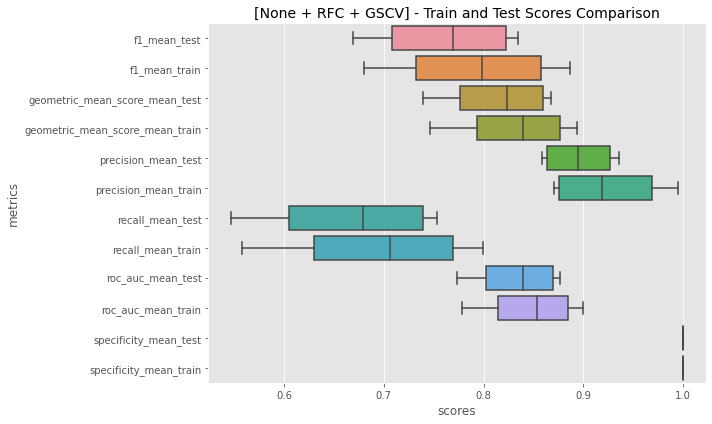

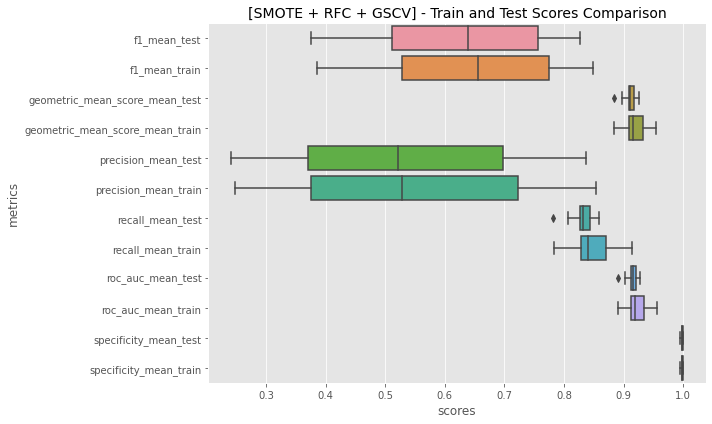

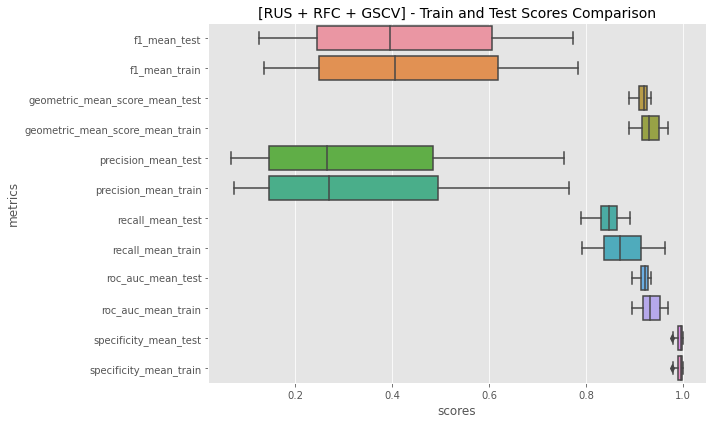

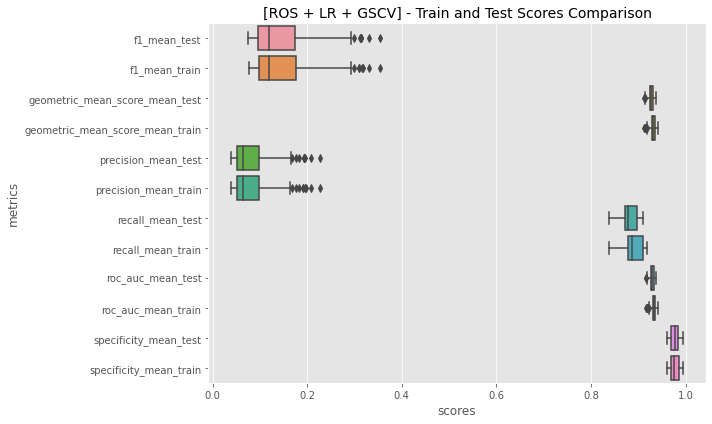

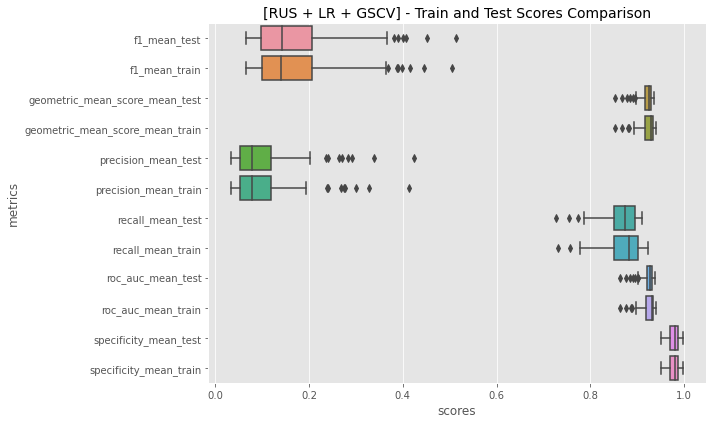

In [11]:
## comparison between train and test scores

metrics = [col for col in df.columns 
           if col.startswith('mean_test_') 
           or col.startswith('mean_train_')]

train_test_comparison = df[['exp_id'] + metrics].melt(
    id_vars=['exp_id'],
    value_vars=metrics,
    var_name='metrics',
    value_name='scores',
    ignore_index=True)

train_test_comparison['metrics'] = train_test_comparison['metrics'].apply(
    lambda string: '_'.join(string.split('_')[2:] + string.split('_')[:2]))

train_test_comparison.sort_values('metrics', inplace=True, ignore_index=True)

for exp in train_test_comparison['exp_id'].unique():
    mask = train_test_comparison['exp_id'] == exp
    train_test_comparison.loc[mask]
    
    _ = plt.figure(figsize=[10,6])
    plt.title(f'[{exp}] - Train and Test Scores Comparison', fontsize=14)
    sns.boxplot(
        data=train_test_comparison.loc[mask],
        x='scores',
        y='metrics',
        orient='h')
    plt.tight_layout()

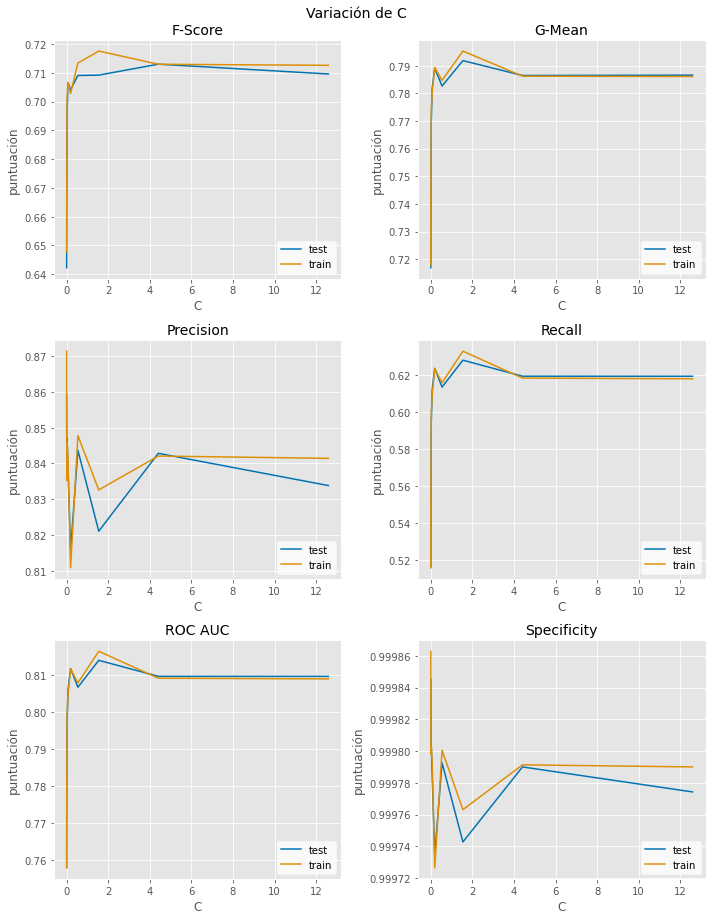

In [12]:
## how C variation does affect LogReg metric scores:

metrics = [col for col in df.columns 
           if col.startswith('mean_test_') 
           or col.startswith('mean_train_')]
mask = df['param_resampling__sampling_strategy'] == ''
cols = ['exp_id', 'param_C'] + metrics

metric_to_plot = [col.replace('mean_test_', '') for col in df.columns 
                  if col.startswith('mean_test_')]
titles = [
    'F-Score', 'G-Mean', 'Precision',
    'Recall', 'ROC AUC', 'Specificity']

_ = plt.figure(figsize=[10,13])
plt.suptitle('Variación de C', fontsize=14)
for index, metric in enumerate(metric_to_plot):
    plt.subplot(3,2,index+1)

    sns.lineplot(
        data=df.loc[mask, cols],
        x='param_C',
        y=f'mean_test_{metric}',
        label=f'test',
        color=COLORS[0])
    sns.lineplot(
        data=df.loc[mask, cols],
        x='param_C',
        y=f'mean_train_{metric}',
        label=f'train',
        color=COLORS[1])
    plt.title(titles[index], fontsize=14)
    plt.ylabel('puntuación')
    plt.xlabel('C')
    plt.legend(loc='lower right', frameon=True)\
        .get_frame().set_color('white')
    
    plt.tight_layout()

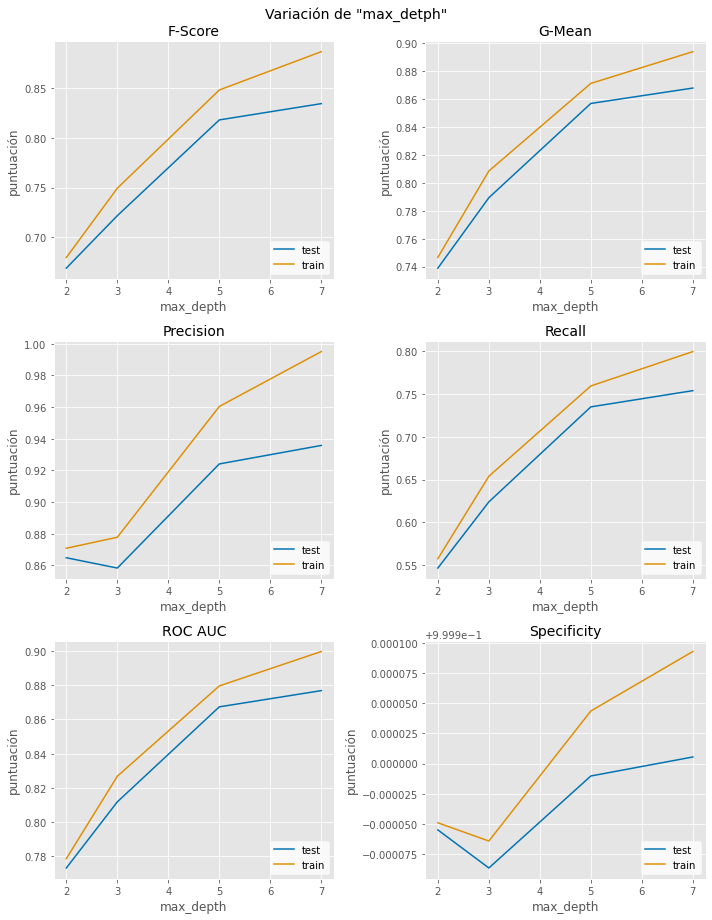

In [13]:
## how MAX_DEPTH variation does affect RanFor metric scores:

metrics = [col for col in df.columns 
           if col.startswith('mean_test_') 
           or col.startswith('mean_train_')]
mask = df['param_resampling__sampling_strategy'] == ''
cols = ['exp_id', 'param_max_depth'] + metrics
metric_to_plot = [col.replace('mean_test_', '') for col in df.columns 
                  if col.startswith('mean_test_')]
_ = plt.figure(figsize=[10,13])
plt.suptitle('Variación de "max_detph"', fontsize=14)
for index, metric in enumerate(metric_to_plot):
    plt.subplot(3,2,index+1)
    
    sns.lineplot(
        data=df.loc[mask, cols],
        x='param_max_depth',
        y=f'mean_test_{metric}',
        label='test',
        color=COLORS[0])
    
    sns.lineplot(
        data=df.loc[mask, cols],
        x='param_max_depth',
        y=f'mean_train_{metric}',
        label='train',
        color=COLORS[1])
    
    plt.title(titles[index], fontsize=14)
    plt.ylabel('puntuación')
    plt.xlabel('max_depth')
    plt.legend(loc='lower right', frameon=True)\
        .get_frame().set_color('white')

plt.tight_layout()

---

In [14]:
train_roc_auc = [col for col in df.columns if 'train_roc_auc' in col]
test_roc_auc = [col for col in df.columns if 'test_roc_auc' in col]
cols

['exp_id',
 'param_max_depth',
 'mean_test_f1',
 'mean_test_geometric_mean_score',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_specificity',
 'mean_train_f1',
 'mean_train_geometric_mean_score',
 'mean_train_precision',
 'mean_train_recall',
 'mean_train_roc_auc',
 'mean_train_specificity']

In [15]:
roc_auc_cols = [col for col in df.columns if 'roc_auc' in col]
cols = ['exp_id', 'params']
df.loc[df['rank_test_roc_auc'] == 1.0, cols + roc_auc_cols]

,exp_id,params,mean_test_roc_auc,mean_train_roc_auc,rank_test_roc_auc,split0_test_roc_auc,split0_train_roc_auc,split1_test_roc_auc,split1_train_roc_auc,split2_test_roc_auc,...,split6_test_roc_auc,split6_train_roc_auc,split7_test_roc_auc,split7_train_roc_auc,split8_test_roc_auc,split8_train_roc_auc,split9_test_roc_auc,split9_train_roc_auc,std_test_roc_auc,std_train_roc_auc
7,None + LR + GSCV,{'C': 1.5448591479026732},0.813949,0.816395,1.0,0.830817,0.796259,0.838078,0.845336,0.818736,...,0.764653,0.798074,0.847708,0.810104,0.825982,0.811942,0.811476,0.811942,0.024982,0.016379
48,ROS + LR + GSCV,"{'estimator__C': 0.02326305067153625, 'resampl...",0.937934,0.939101,1.0,0.954904,0.944814,0.930969,0.940680,0.928064,...,0.938728,0.941529,0.921592,0.953267,0.935180,0.909099,0.928615,0.947323,0.014166,0.011230
184,RUS + LR + GSCV,"{'estimator__C': 1.5448591479026732, 'resampli...",0.936875,0.940465,1.0,0.943676,0.939198,0.927422,0.944427,0.937870,...,0.930559,0.943277,0.918559,0.948031,0.948530,0.932006,0.917758,0.945593,0.013729,0.005292
279,SMOTE + LR + GSCV,"{'estimator__C': 0.5411695265464632, 'resampli...",0.935307,0.936779,1.0,0.919124,0.915828,0.933564,0.937947,0.926908,...,0.947824,0.937944,0.910787,0.942649,0.953846,0.935888,0.913202,0.941565,0.016410,0.007405
313,None + RFC + GSCV,{'max_depth': 7},0.876775,0.899596,1.0,0.867621,0.901818,0.874934,0.899997,0.869513,...,0.874974,0.894542,0.898498,0.899632,0.891239,0.899628,0.840553,0.905109,0.015343,0.002845
333,ROS + RFC + GSCV,"{'estimator__max_depth': 3, 'resampling__sampl...",0.925213,0.936730,1.0,0.916112,0.935367,0.915482,0.938173,0.925515,...,0.922979,0.934536,0.903605,0.939316,0.961458,0.931934,0.903264,0.941042,0.017227,0.002640
391,RUS + RFC + GSCV,"{'estimator__max_depth': 7, 'resampling__sampl...",0.934209,0.969331,1.0,0.933472,0.969253,0.916456,0.973586,0.931581,...,0.946446,0.969007,0.927577,0.972098,0.956667,0.971274,0.908253,0.967578,0.013587,0.003427
433,SMOTE + RFC + GSCV,"{'estimator__max_depth': 7, 'resampling__sampl...",0.927867,0.955800,1.0,0.924856,0.951415,0.917556,0.951224,0.911810,...,0.932222,0.956699,0.904485,0.958561,0.961773,0.958089,0.904839,0.953307,0.017863,0.002741


In [16]:
roc_auc_cols = [col for col in df.columns if 'roc_auc' in col and 'rank' not in col]
cols = ['exp_id', 'params'] + roc_auc_cols
df_best_params = df.loc[df['rank_test_roc_auc'] == 1.0, cols] \
    .melt(id_vars=['exp_id', 'params'], var_name='metric', value_name='score')

In [17]:
df_best_params.loc[df_best_params['metric'].str.contains('split[0-9]_test'), 'metric'] = 'split_test_roc_auc'
df_best_params.loc[df_best_params['metric'].str.contains('split[0-9]_train'), 'metric'] = 'split_train_roc_auc'

In [18]:
df_best_params['metric'].unique()

array(['mean_test_roc_auc', 'mean_train_roc_auc', 'split_test_roc_auc',
       'split_train_roc_auc', 'std_test_roc_auc', 'std_train_roc_auc'],
      dtype=object)

In [19]:
# df_best_params = df_best_params.groupby(['exp_id', 'metric']).mean().reset_index()
# df_best_params.pivot(index='exp_id', columns='metric', values='score')

<AxesSubplot:xlabel='metric', ylabel='score'>

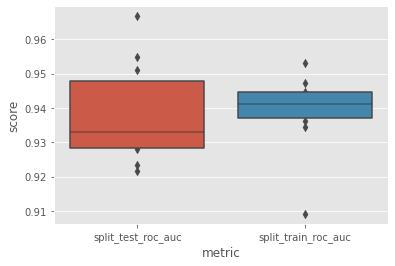

In [20]:
data_to_plot = df_best_params[
    (df_best_params['exp_id'] == 'ROS + LR + GSCV') & 
    (df_best_params['metric'].str.contains('split'))]

sns.boxenplot(
    data=data_to_plot,
    x='metric',
    y='score'
)

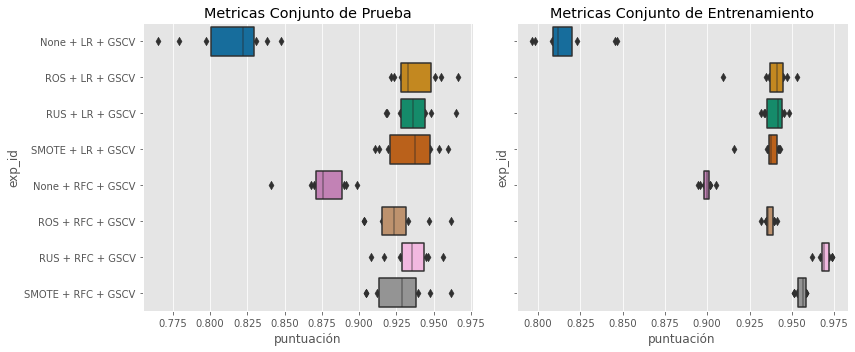

In [21]:
_ = plt.figure(figsize=[12,5])

plt.subplot(1,2,1)
sns.boxenplot(
    data=df_best_params[df_best_params['metric'].str.contains('split_test_')],
    x='score', y='exp_id', palette='colorblind')
plt.title('Metricas Conjunto de Prueba')
plt.xlabel('puntuación')

plt.subplot(1,2,2)
sns.boxenplot(
    data=df_best_params[df_best_params['metric'].str.contains('split_train_')],
    x='score', y='exp_id', palette='colorblind')
plt.title('Metricas Conjunto de Entrenamiento')
plt.xlabel('puntuación')
plt.tick_params(labelleft = False)

plt.tight_layout()

In [23]:
describe_df = df_best_params.loc[
    df_best_params['metric'].str.contains('split'), 
    ['exp_id', 'metric', 'score']
].groupby(['exp_id', 'metric']).max()
describe_df.rename(columns={'score': 'max'}, inplace=True)
describe_df['min'] = df_best_params.loc[
    df_best_params['metric'].str.contains('split'), 
    ['exp_id', 'metric', 'score']
].groupby(['exp_id', 'metric']).min()['score']

# describe_df.pivot()

In [24]:
roc_auc_cols = [col for col in df.columns if 'roc_auc' in col and 'rank' not in col]
cols = ['exp_id', 'params'] + roc_auc_cols
df.loc[df['rank_test_roc_auc'] == 1.0, cols]

,exp_id,params,mean_test_roc_auc,mean_train_roc_auc,split0_test_roc_auc,split0_train_roc_auc,split1_test_roc_auc,split1_train_roc_auc,split2_test_roc_auc,split2_train_roc_auc,...,split6_test_roc_auc,split6_train_roc_auc,split7_test_roc_auc,split7_train_roc_auc,split8_test_roc_auc,split8_train_roc_auc,split9_test_roc_auc,split9_train_roc_auc,std_test_roc_auc,std_train_roc_auc
7,None + LR + GSCV,{'C': 1.5448591479026732},0.813949,0.816395,0.830817,0.796259,0.838078,0.845336,0.818736,0.822904,...,0.764653,0.798074,0.847708,0.810104,0.825982,0.811942,0.811476,0.811942,0.024982,0.016379
48,ROS + LR + GSCV,"{'estimator__C': 0.02326305067153625, 'resampl...",0.937934,0.939101,0.954904,0.944814,0.930969,0.940680,0.928064,0.943841,...,0.938728,0.941529,0.921592,0.953267,0.935180,0.909099,0.928615,0.947323,0.014166,0.011230
184,RUS + LR + GSCV,"{'estimator__C': 1.5448591479026732, 'resampli...",0.936875,0.940465,0.943676,0.939198,0.927422,0.944427,0.937870,0.944359,...,0.930559,0.943277,0.918559,0.948031,0.948530,0.932006,0.917758,0.945593,0.013729,0.005292
279,SMOTE + LR + GSCV,"{'estimator__C': 0.5411695265464632, 'resampli...",0.935307,0.936779,0.919124,0.915828,0.933564,0.937947,0.926908,0.942848,...,0.947824,0.937944,0.910787,0.942649,0.953846,0.935888,0.913202,0.941565,0.016410,0.007405
313,None + RFC + GSCV,{'max_depth': 7},0.876775,0.899596,0.867621,0.901818,0.874934,0.899997,0.869513,0.901457,...,0.874974,0.894542,0.898498,0.899632,0.891239,0.899628,0.840553,0.905109,0.015343,0.002845
333,ROS + RFC + GSCV,"{'estimator__max_depth': 3, 'resampling__sampl...",0.925213,0.936730,0.916112,0.935367,0.915482,0.938173,0.925515,0.939716,...,0.922979,0.934536,0.903605,0.939316,0.961458,0.931934,0.903264,0.941042,0.017227,0.002640
391,RUS + RFC + GSCV,"{'estimator__max_depth': 7, 'resampling__sampl...",0.934209,0.969331,0.933472,0.969253,0.916456,0.973586,0.931581,0.962065,...,0.946446,0.969007,0.927577,0.972098,0.956667,0.971274,0.908253,0.967578,0.013587,0.003427
433,SMOTE + RFC + GSCV,"{'estimator__max_depth': 7, 'resampling__sampl...",0.927867,0.955800,0.924856,0.951415,0.917556,0.951224,0.911810,0.956910,...,0.932222,0.956699,0.904485,0.958561,0.961773,0.958089,0.904839,0.953307,0.017863,0.002741
